<a href="https://colab.research.google.com/github/ShuHuiK/WIE3007_Group_Assignment/blob/cindy/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Develop Model (Xgboost)**

Import Required Libraries

In [489]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

Load Dataset

In [490]:
df = pd.read_csv("2025_Sterling_Financial_Dataset_clean.csv")

df.head()

,date,customer_id,location,business_sector,age,income,credit_score,savings_ratio,loan_amount,debt_to_income,credit_utilization,payment_punctuality,customer_feedback,default_history,sentiment,risk_category,customer_segment,feedback_topic
0,2025-04-15,CUST-2025000,"South Dakota, US",Real Estate,39,93096.98,782,0.058,2692.74,0.133,0.93,91.49,Standard banking,0,Neutral,Medium Risk,Mass Market,General Service
1,2025-10-22,CUST-2025001,"Connecticut, US",Retail,38,25000.00,716,0.042,43350.56,0.187,0.75,85.26,Neutral: No feedback provided.,0,Neutral,Medium Risk,Mass Market,Financial/Pricing
2,2025-02-26,CUST-2025002,"Connecticut, US",Services,34,42377.97,657,0.193,5856.85,0.103,0.62,84.18,Process was slow,0,Negative,Medium Risk,Mass Market,Digital/Operations
3,2025-02-26,CUST-2025003,"Connecticut, US",Manufacturing,44,27556.02,606,0.136,17789.75,0.091,0.62,88.10,Excellent rates,0,Positive,Medium Risk,Mass Market,Financial/Pricing
4,2025-09-15,CUST-2025004,"New Mexico, US",Retail,49,25000.00,578,0.010,70266.78,0.229,0.90,85.24,Quick approval,0,Positive,High Risk,Mass Market,Digital/Operations


Define Target and Features

In [491]:
target = "default_history"

X = df.drop(columns=[target])
y = df[target]

Feature Grouping

In [492]:
numerical_features = [
    "age",
    "credit_score",
    "savings_ratio",
    "loan_amount",
    "debt_to_income",
    "credit_utilization",
    "payment_punctuality",
    "income"
]

categorical_features = [
    "location",
    "business_sector",
    "risk_category",
    "customer_segment",
    "feedback_topic",
    "sentiment"
]

Encode Ordinal Sentiment Feature

In [493]:
sentiment_map = {
    "Negative": -1,
    "Neutral": 0,
    "Positive": 1
}

df["sentiment"] = df["sentiment"].map(sentiment_map)

Preprocessing Pipeline

In [494]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

Train-Test Split

In [495]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Handle Class Imbalance (scale_pos_weight)

In [496]:
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
scale_pos_weight

np.float64(17.75)

Build XGBoost Model Pipeline

In [497]:
xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=42
    ))
])

Train the Model

In [498]:
xgb_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['age', 'credit_score',
                                                   'savings_ratio',
                                                   'loan_amount',
                                                   'debt_to_income',
                                                   'credit_utilization',
                                                   'payment_punctuality',
                                                   'income']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['location',
                                                   'business_sector',
                                                   'risk_category',
                                                   'customer_segment',
                                                   'feedback_topic',
                                                   'sentiment'])]...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

Make Predictions

In [499]:
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

<br>

### **Model Evaluation**

Model Evaluation Metrics

In [500]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Model Accuracy : {accuracy:.4f}")
print(f"F1-score       : {f1:.4f}")
print(f"ROC-AUC        : {roc_auc:.4f}")

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Model Accuracy : 0.8967
F1-score       : 0.1143
ROC-AUC        : 0.7756
Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.98      0.95       272
           1       0.29      0.07      0.11        28

    accuracy                           0.90       300
   macro avg       0.60      0.53      0.53       300
weighted avg       0.85      0.90      0.87       300



ROC Curve Visualization

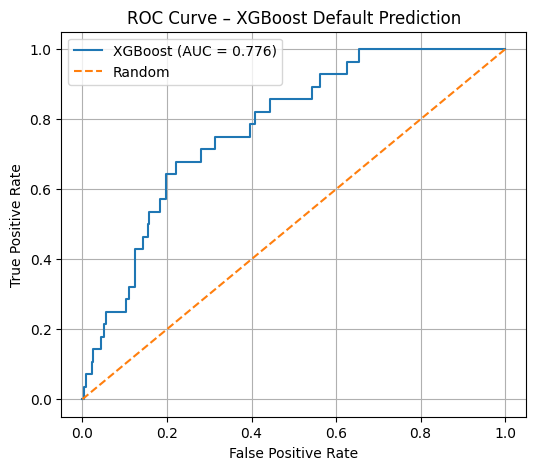

In [501]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – XGBoost Default Prediction')
plt.legend()
plt.grid(True)
plt.show()

Confusion Matrix Visualization

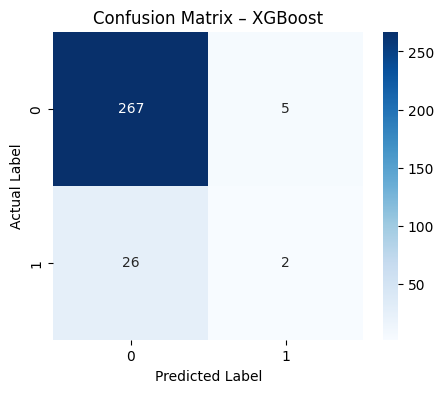

In [502]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix – XGBoost")
plt.show()

<br>

### **Feature Importance**

Extract Feature Names

In [503]:
xgb_clf = xgb_model.named_steps["model"]
importances = xgb_clf.feature_importances_

Get feature names after encoding

In [504]:
num_features = numerical_features

cat_features_encoded = (
    xgb_model.named_steps['preprocessor']
    .named_transformers_['cat']
    .get_feature_names_out(categorical_features)
)

all_features = np.concatenate([num_features, cat_features_encoded])

Create Feature Importance DataFrame

In [505]:
importance_df = pd.DataFrame({
    "Feature": all_features,
    "Importance": importances
})

Map Encoded Features Back to Original Feature Names

In [506]:
def original_feature_name(feature):
    # Numerical features stay the same
    if feature in numerical_features:
        return feature
    # One-hot encoded features → take original column name
    return feature.split("_")[0]

Assign Original Feature Names

In [507]:
importance_df["Features"] = importance_df["Feature"].apply(original_feature_name)

Aggregate Feature Importance by Original Feature

In [508]:
aggregated_importance = (
    importance_df
    .groupby("Features", as_index=False)["Importance"]
    .sum()
    .sort_values(by="Importance", ascending=False)
)

Display Top 10 Features

In [509]:
aggregated_importance.head(10)

,Features,Importance
9,location,0.549761
1,business,0.094563
11,risk,0.072560
4,customer,0.067049
6,feedback,0.056497
13,sentiment,0.035227
2,credit_score,0.023027
5,debt_to_income,0.020589
12,savings_ratio,0.018567
8,loan_amount,0.014758


Plot Feature Importance (Top 10)

/tmp/ipython-input-2643245519.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Features', data=aggregated_importance.head(10), palette='viridis')


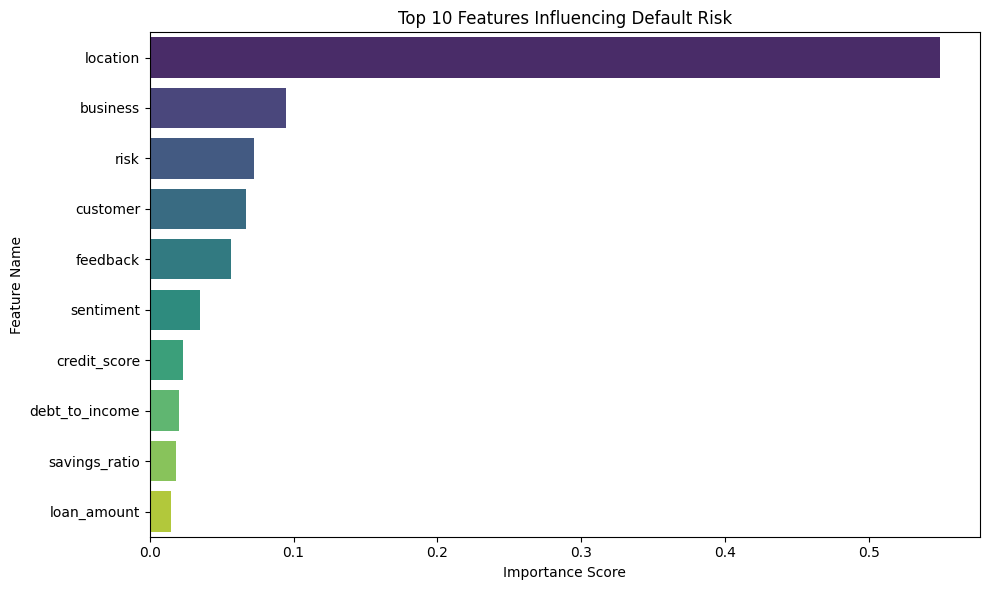

In [510]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Features', data=aggregated_importance.head(10), palette='viridis')

plt.title('Top 10 Features Influencing Default Risk')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

<br>